- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

## Chapter 9 - Hierarchical Models

In [11]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec
from scipy.stats import mode

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 45)

%matplotlib inline
plt.style.use('seaborn-white')

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

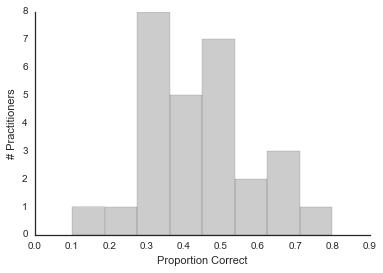

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

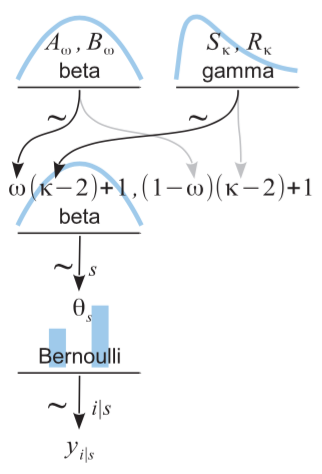

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
le = preprocessing.LabelEncoder()
practitioner_idx = le.fit_transform(df.s)

practitioner_codes = df.s.unique()
n_practitioners = len(practitioner_codes)

with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2

    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=n_practitioners)
    
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [6]:
with hierarchical_model:
    start = pmc.find_MAP()
    step = pmc.NUTS(state=start)
        
    trace= pmc.sample(20000, step, start=start)

 [-----------------100%-----------------] 20000 of 20000 complete in 147.1 sec

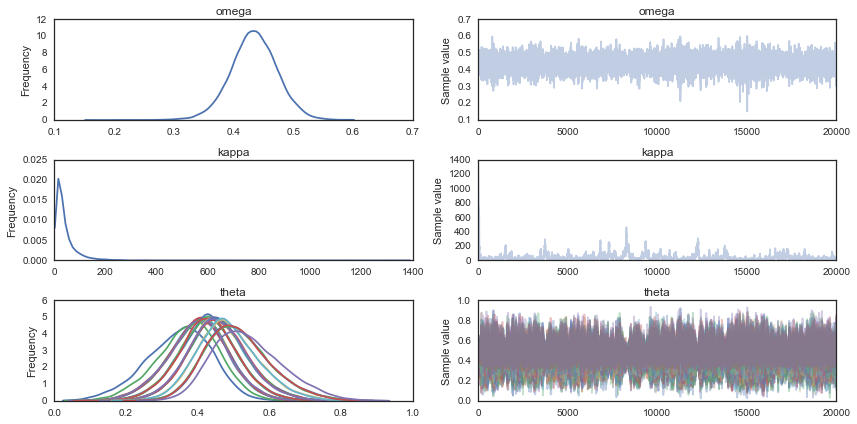

In [7]:
pmc.traceplot(trace);

In [8]:
pmc.df_summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

                mean         sd  mc_error   hpd_2.5    hpd_97.5
omega       0.434122   0.039387  0.000492  0.358069    0.513216
kappa      41.742713  61.593700  3.651020  1.454957  120.705068
theta__0    0.346741   0.092268  0.002796  0.162082    0.522379
theta__1    0.374078   0.087420  0.001966  0.194093    0.536841
theta__2    0.400881   0.086537  0.001294  0.226681    0.572147
theta__3    0.400886   0.084373  0.001241  0.227666    0.561245
theta__4    0.401460   0.084789  0.001196  0.229973    0.567381
theta__5    0.400826   0.084110  0.001219  0.226593    0.562168
theta__6    0.401341   0.085188  0.001222  0.225117    0.562027
theta__7    0.401721   0.085352  0.001248  0.230692    0.570550
theta__8    0.401060   0.084425  0.001197  0.225663    0.561702
theta__9    0.401829   0.085791  0.001259  0.231798    0.573203
theta__10   0.429036   0.083520  0.000636  0.263446    0.595138
theta__11   0.428642   0.085622  0.000701  0.255220    0.598141
theta__12   0.428887   0.084171  0.00061

#### Marginal posterior distributions

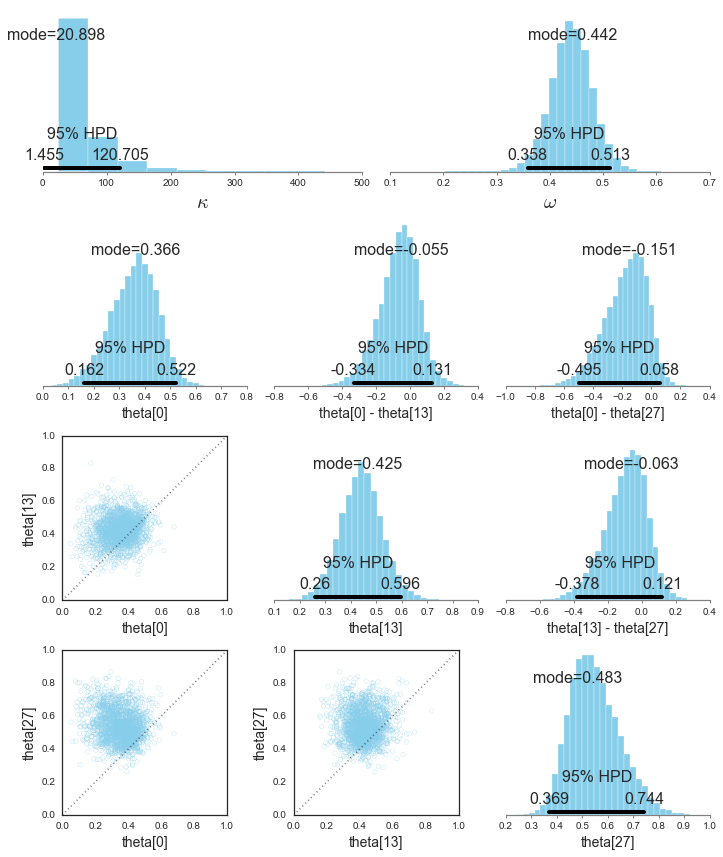

In [9]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

font_d = {'size':14}
color = '#87ceeb'

# kappa posterior plot
pmc.plot_posterior(trace['kappa'], point_estimate='mode', ax=ax1, color=color)
ax1.set(xlim=(0,500))
ax1.set_xlabel('$\kappa$', fontdict={'size':20, 'weight':'bold'})

# omega posterior plot
pmc.plot_posterior(trace['omega'], point_estimate='mode', ax=ax2, color=color)
ax2.set_xlabel('$\omega$', fontdict={'size':20, 'weight':'bold'})

# theta posterior plots
pmc.plot_posterior(trace['theta'][:,0], point_estimate='mode', ax=ax3, color=color)
ax3.set_xlabel('theta[0]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13], point_estimate='mode', ax=ax7, color=color)
ax7.set_xlabel('theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,27], point_estimate='mode', ax=ax11, color=color)
ax11.set_xlabel('theta[27]', fontdict=font_d)

# theta scatter plots
ax6.scatter(trace['theta'][::10,0], trace['theta'][::10,13], alpha=0.75, color=color, facecolor='none')
ax6.plot([0, 1], [0, 1], ':k', transform=ax6.transAxes, alpha=0.5)
ax6.set_xlabel('theta[0]', fontdict=font_d)
ax6.set_ylabel('theta[13]', fontdict=font_d)

ax9.scatter(trace['theta'][::10,0], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax9.plot([0, 1], [0, 1], ':k', transform=ax9.transAxes, alpha=0.5)
ax9.set_xlabel('theta[0]', fontdict=font_d)
ax9.set_ylabel('theta[27]', fontdict=font_d)

ax10.scatter(trace['theta'][::10,13], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax10.plot([0, 1], [0, 1], ':k', transform=ax10.transAxes, alpha=0.5)
ax10.set_xlabel('theta[13]', fontdict=font_d)
ax10.set_ylabel('theta[27]', fontdict=font_d)

for ax in [ax6, ax9, ax10]:
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal') 
    
# theta posterior differences plots
pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,14], point_estimate='mode', ax=ax4, color=color)
ax4.set_xlabel('theta[0] - theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,27], point_estimate='mode', ax=ax5, color=color)
ax5.set_xlabel('theta[0] - theta[27]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13]-trace['theta'][:,27], point_estimate='mode', ax=ax8, color=color)
ax8.set_xlabel('theta[13] - theta[27]', fontdict=font_d)

plt.tight_layout();

### 9.5.1 - Example: Baseball batting abilities by position

In [235]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null object
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: int64(2), object(2)
memory usage: 29.7+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [236]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

           Player      PriPos  Hits  AtBats     BatAv
0   Fernando Abad     Pitcher     1       7  0.142857
1     Bobby Abreu  Left Field    53     219  0.242009
2      Tony Abreu    2nd Base    18      70  0.257143
3   Dustin Ackley    2nd Base   137     607  0.225700
4      Matt Adams    1st Base    21      86  0.244186
5   Nathan Adcock     Pitcher     0       1  0.000000
6  Jeremy Affeldt     Pitcher     0       1  0.000000
7   Brandon Allen    1st Base     2      20  0.100000
8   Yonder Alonso    1st Base   150     549  0.273224
9     Jose Altuve    2nd Base   167     576  0.289931

#### Model (Kruschke, 2015)

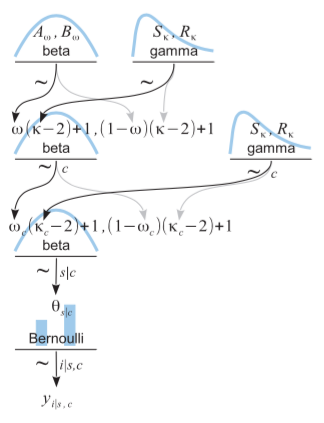

In [237]:
Image('images/fig9_13.png', width=400)

In [238]:
le = preprocessing.LabelEncoder()

# Encode the 9 primary field positions
pripos_idx = le.fit_transform(df2.PriPos)
pripos_codes = le.classes_
n_pripos = len(le.classes_)

# df2 contains one entry per player
n_players = len(df2.index)

with pmc.Model() as hierarchical_model2:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2 
    
    omega_c = pmc.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c = pmc.Gamma('kappa_c',
                        0.01, 0.01,
                        shape = n_pripos)+2

    theta = pmc.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1, (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y = pmc.Binomial('y', 1, theta, observed=df2.BatAv)

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to omega_c and added transformed omega_c_logodds_ to model.
Applied log-transform to kappa_c and added transformed kappa_c_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [239]:
with hierarchical_model2:
    step = pmc.NUTS()
    trace = pmc.sample(10000, step, start=None, trace=None)

 [-----------------100%-----------------] 10000 of 10000 complete in 436.0 sec

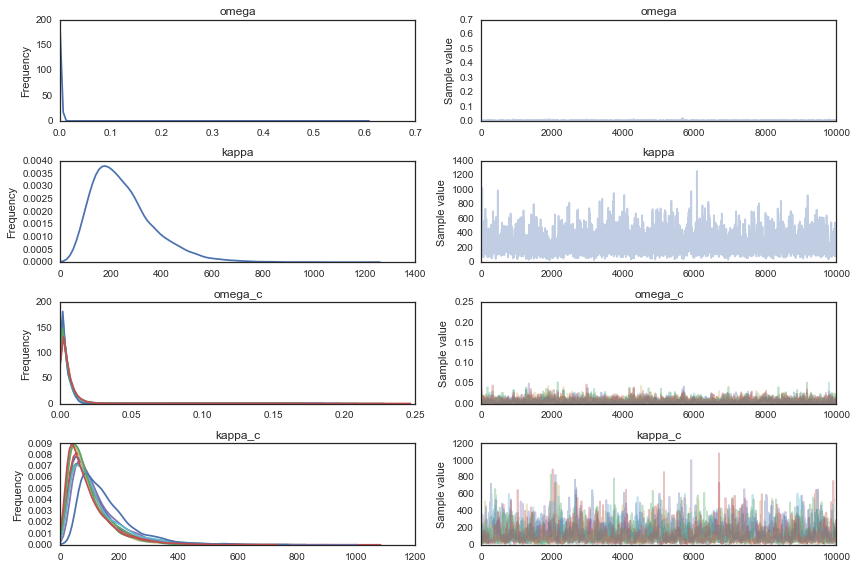

In [240]:
pmc.traceplot(trace, varnames=['omega', 'kappa', 'omega_c', 'kappa_c']);

In [241]:
pmc.df_summary(trace)

                  mean          sd  mc_error       hpd_2.5    hpd_97.5
omega         0.001640    0.008715  0.000129  9.763073e-07    0.004520
kappa       249.193792  124.300094  3.761524  5.622748e+01  496.122420
omega_c__0    0.004526    0.004415  0.000172  1.185194e-06    0.012646
omega_c__1    0.004730    0.005773  0.000193  2.442654e-06    0.014382
omega_c__2    0.004277    0.004524  0.000149  2.882881e-06    0.012012
omega_c__3    0.004391    0.005047  0.000187  1.134190e-06    0.012411
omega_c__4    0.004699    0.004529  0.000147  1.905475e-06    0.013245
omega_c__5    0.003817    0.004781  0.000165  1.500255e-07    0.010928
omega_c__6    0.003532    0.003937  0.000204  1.842258e-06    0.009726
omega_c__7    0.004788    0.005202  0.000172  2.762029e-06    0.013865
omega_c__8    0.004876    0.005742  0.000165  7.503121e-07    0.013754
kappa_c__0  108.116388   76.897735  4.121043  1.275799e+01  259.691364
kappa_c__1  115.135259   91.132612  5.105103  9.471383e+00  312.026793
kappa_

##### Posterior distributions of the omega_c parameters after sampling. Looking at the trace up till step 4000, before it starts looking weird.
They are neither reasonable nor comparable to the ones from Kruschke. Why?

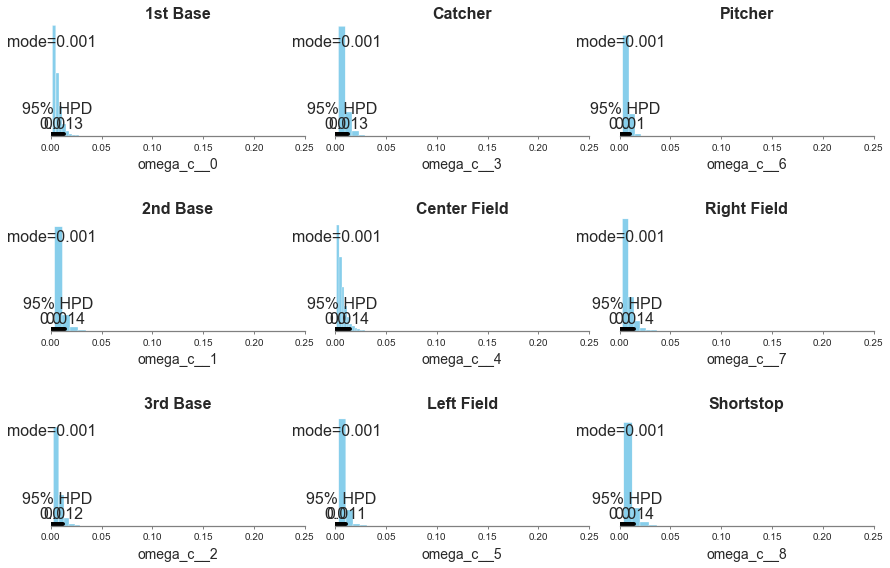

In [242]:
step_limit = 5000

fig, axes = plt.subplots(3,3, figsize=(12,8))
for i, ax in enumerate(axes.T.flatten()):
    pmc.plot_posterior(trace['omega_c'][:step_limit,i], ax=ax, point_estimate='mode', color='#87ceeb')
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0,0.25)
plt.tight_layout(h_pad=3)

##### The below image from the book shows the __omega_c__ distributions obtained by JAGS/R

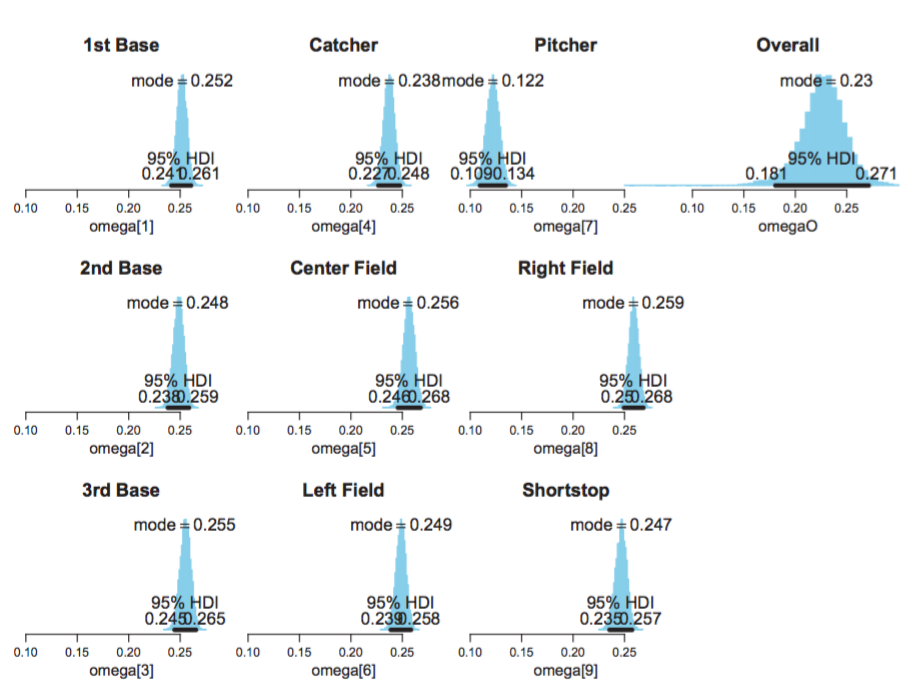

In [243]:
Image('images/fig9_17.png')